# Regression of pH range using machine learning

In [1]:
#libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn import preprocessing as pp
import seaborn as sns

## Data

In [2]:
# load data
acidoCEST_ML = pd.read_parquet('../clean_data/acido_CEST_MRI_Iopamidol.parquet.gzip')

# drop columns we cannot measure or that are redundant
cols_2_drop = ['ApproT1(sec)','Temp','ExpB0(ppm)','FILE','Conc(mM)']
acidoCEST_ML = acidoCEST_ML.drop(cols_2_drop, axis = 1)

In [3]:
# define experimental columns -- > things we measure other than CEST
exper_cols = [ 'ExpB1(percent)', 'ExpB0(Hz)', 'SatPower(uT)',  'SatTime(ms)','ExpT1(ms)', 'ExpT2(ms)']

In [4]:
# used during development
# acidoCEST_ML  = acidoCEST_ML.sample( n = 1_00)

In [5]:
acidoCEST_ML.shape

(20000, 88)

## Functions

In [6]:
# Regression
from sklearn.metrics import confusion_matrix, classification_report
    
def train_lasso(Xdata, pH_observed, create_fig = 1, verbose=0):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, pH_observed, test_size=0.30, random_state=42)
    
    # LASSO
    lasso = linear_model.Lasso( max_iter = 5000, random_state=42)

    #pipeline
    pipe = Pipeline(steps=[('Scaler', pp.StandardScaler()), ('lasso', lasso)])

    param_grid ={
            'lasso__alpha': np.linspace(.01,1,20),
            'lasso__fit_intercept': [True,False]
            }

    scorer = metrics.make_scorer( metrics.mean_absolute_percentage_error, greater_is_better=False) 


    estimator = GridSearchCV(pipe, param_grid, verbose = verbose, cv = 3, n_jobs= 6, scoring=scorer )


    # fit
    estimator.fit(X_train, y_train)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(y_train , estimator.predict(X_train)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(y_test , estimator.predict(X_test)), 2)
    
    #score on pH units
    score_pH_train = np.mean( np.abs(  y_train -  estimator.predict(X_train) ) )
    score_pH_test = np.mean( np.abs(  y_test -  estimator.predict(X_test) ) )

    m  = f'\n mean absolute percentage error: \n train = {score_train} % \n test  = {score_test} %'
    m2 = f'\n pH units |error : \ntrain = {score_pH_train:.3f} \n test = {score_pH_test:.3f}'

    if create_fig == 1:
        print('------------------ LASSO ------------------ ')
        print()
        #print(', '.join(Xdata.columns.to_list()))
        print(m,'\n',m2,'\n')

        plt.figure()
        sns.regplot(x = estimator.best_estimator_.predict(X_train), y =  y_train)
        plt.xlabel('\n Predicted pH')
        plt.ylabel('Measured pH \n')
        plt.title('Train LASSO')

        plt.figure()
        sns.regplot(x = estimator.best_estimator_.predict(X_test), y =  y_test)
        plt.xlabel('\n Predicted pH')
        plt.ylabel('Measured pH \n')
        plt.title('Test LASSO')
    
    
    scores = dict()
    scores['mae_train'] = score_train
    scores['mae_test'] = score_test
    scores['pH_train'] = score_pH_train
    scores['pH_test'] = score_pH_test
    
    test_data = dict()
    test_data['X'] = X_test
    test_data['Y'] = y_test
    
    return estimator.best_estimator_, scores, test_data

## LASSO

### -- 4.2 and 5.6 only

Fitting 3 folds for each of 40 candidates, totalling 120 fits
------------------ LASSO ------------------ 


 mean absolute percentage error: 
 train = 3.99 % 
 test  = 4.01 % 
 
 pH units |error : 
train = 0.269 
 test = 0.270 

CPU times: user 1.86 s, sys: 1.24 s, total: 3.1 s
Wall time: 2.27 s


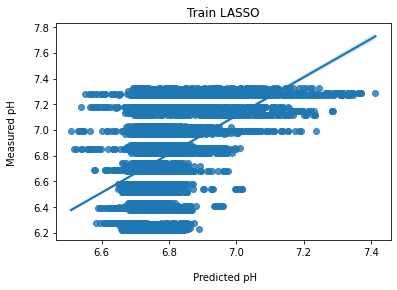

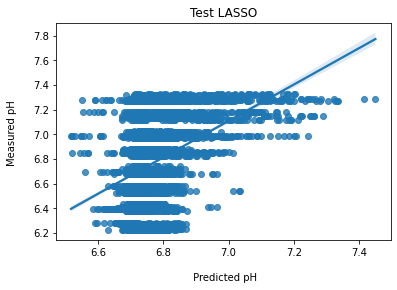

In [7]:
%%time

X = acidoCEST_ML[['4.2','5.6']]
Y = acidoCEST_ML.pH
reg_lr, _ , _ = train_lasso(X,Y, verbose=1)

### -- All Saturation Frequencies

(20000, 81)
Fitting 3 folds for each of 40 candidates, totalling 120 fits
------------------ LASSO ------------------ 


 mean absolute percentage error: 
 train = 3.56 % 
 test  = 3.59 % 
 
 pH units |error : 
train = 0.240 
 test = 0.242 

CPU times: user 4.2 s, sys: 873 ms, total: 5.07 s
Wall time: 3.77 s


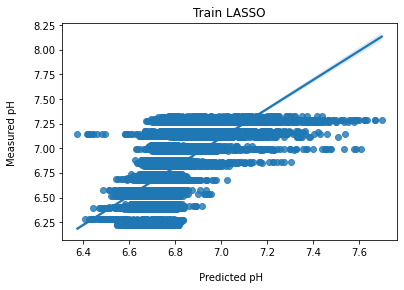

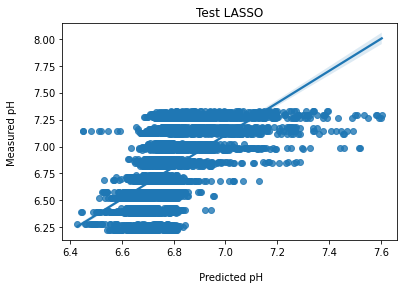

In [8]:
%%time

Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 
print(Xdata.shape)
reg_lr2, _ , _ = train_lasso(Xdata,Ydata, verbose=1)

### -- All data

(20000, 87)
Fitting 3 folds for each of 40 candidates, totalling 120 fits
------------------ LASSO ------------------ 


 mean absolute percentage error: 
 train = 3.54 % 
 test  = 3.59 % 
 
 pH units |error : 
train = 0.238 
 test = 0.242 

CPU times: user 4.43 s, sys: 822 ms, total: 5.25 s
Wall time: 4.5 s


Lasso(alpha=0.01, max_iter=5000, random_state=42)

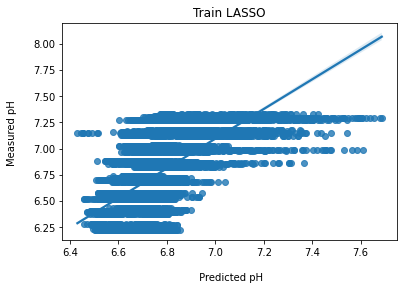

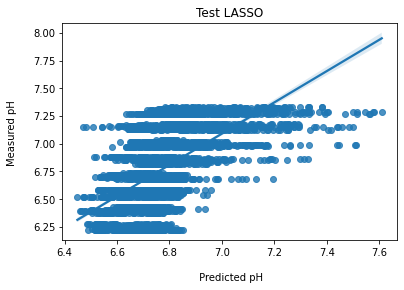

In [9]:
%%time

Xdata = acidoCEST_ML.drop( ['pH'],axis=1) 
Ydata = acidoCEST_ML.pH
print(Xdata.shape)
lasso_all_data, _, _  = train_lasso(Xdata,Ydata, verbose=1)

lasso_all_data['lasso']

### -- selected features

#### | - all selected

CPU times: user 69.4 ms, sys: 10.6 ms, total: 80 ms
Wall time: 53.4 ms


Text(0, 0.5, 'Value \n')

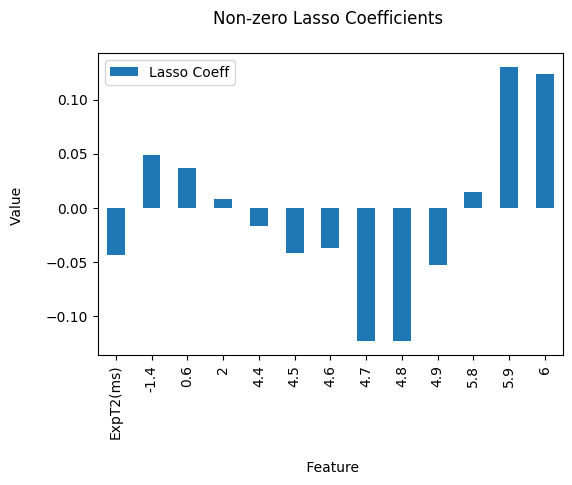

In [10]:
%%time

reg_lasso = lasso_all_data['lasso']

C = pd.DataFrame( reg_lasso.coef_ , columns=['Lasso Coeff'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100)

C[reg_lasso.coef_ != 0].plot(kind='bar', ax = ax)
plt.title('Non-zero Lasso Coefficients \n')
plt.xlabel('\n Feature')
plt.ylabel('Value \n')

Fitting 3 folds for each of 40 candidates, totalling 120 fits
------------------ LASSO ------------------ 


 mean absolute percentage error: 
 train = 3.54 % 
 test  = 3.59 % 
 
 pH units |error : 
train = 0.238 
 test = 0.242 

CPU times: user 3.3 s, sys: 539 ms, total: 3.84 s
Wall time: 1.41 s


Lasso(alpha=0.01, max_iter=5000, random_state=42)

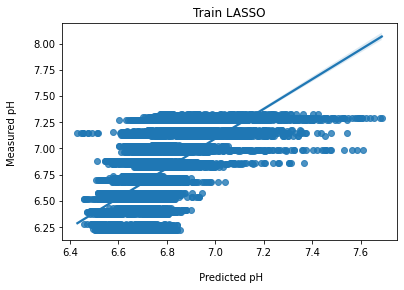

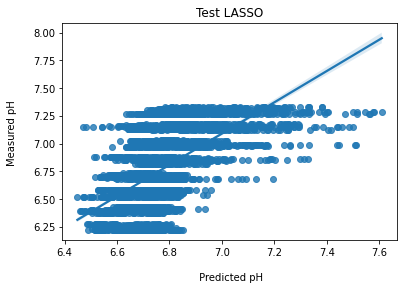

In [14]:
%%time

selected_cols_lasso = list(C[reg_lasso.coef_ != 0].index) # all data are non zero

Xdata = acidoCEST_ML[selected_cols_lasso]
Ydata = acidoCEST_ML.pH

lasso_selected, scores, tes_data_selected_features = train_lasso(Xdata[selected_cols_lasso],Ydata, verbose=1)

lasso_selected['lasso']

## Features selected

In [23]:
pd.Series(selected_cols_lasso)

0     ExpT2(ms)
1          -1.4
2           0.6
3             2
4           4.4
5           4.5
6           4.6
7           4.7
8           4.8
9           4.9
10          5.8
11          5.9
12            6
dtype: object

#### | - sat power vs  sat time

CPU times: user 3.32 s, sys: 320 ms, total: 3.64 s
Wall time: 4.6 s


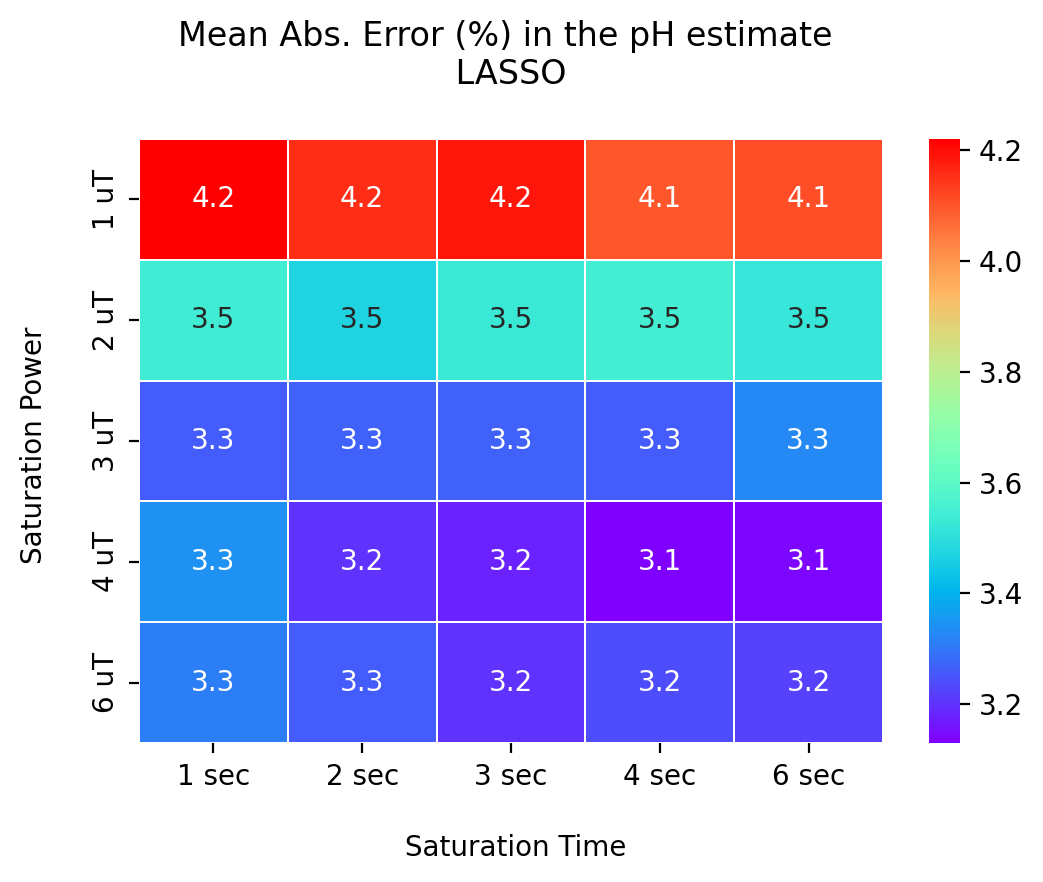

In [19]:
%%time

sat_times = acidoCEST_ML['SatTime(ms)'].unique()
#sat_times.sort()

sat_powers = acidoCEST_ML['SatPower(uT)'].unique()
#sat_powers.sort()

M_lasso = pd.DataFrame(np.zeros( (len(sat_powers), len(sat_powers))), index=sat_powers, columns=sat_times)

for t in sat_times:
    for p in sat_powers:
        D = acidoCEST_ML[(acidoCEST_ML['SatTime(ms)'] == t) & (acidoCEST_ML['SatPower(uT)'] == p) ]

        Xdata = D[selected_cols_lasso]
        Ydata = D['pH']
        
        lasso_selected, scores, _ = train_lasso(Xdata,Ydata, create_fig=0)
        M_lasso.loc[p,:][t] = scores['mae_test']

M_lasso.columns = [str(int(x/1000)) + ' sec'  for x in M_lasso.columns]
M_lasso.index   = [f'{int(x)} uT' for  x in M_lasso.index ]

_, ax = plt.subplots(dpi=200)

cols_ = list(M_lasso.columns)
cols_.sort()

idx = list(M_lasso.index)
idx.sort()


sns.heatmap(M_lasso.loc[idx,:][cols_], cmap='rainbow',annot=True,linewidths=.1,ax=ax)
plt.xlabel('\n Saturation Time')
plt.ylabel('Saturation Power \n')
plt.title('Mean Abs. Error (%) in the pH estimate \n LASSO \n')

plt.savefig(f'../figs/MATRIX_regression_LASSO.png',bbox_inches='tight')

## Predictions for test data using selected features

In [29]:
yhat = lasso_selected.predict( tes_data_selected_features['X'] )

out = pd.DataFrame(yhat, columns=['Predicted_pH_LASSO_TEST'])
out['Measured_pH_TEST'] = tes_data_selected_features['Y'].values
out.to_csv('../outputs/lasso_reg_TEST_pred.csv')

out

,Predicted_pH_LASSO_TEST,Measured_pH_TEST
0,6.475934,6.28
1,6.820474,7.27
2,6.875879,7.14
3,6.949466,6.26
4,6.836026,6.87
...,...,...
5995,6.879028,7.13
5996,6.733517,6.52
5997,6.636480,6.25
5998,6.954036,7.29
